In [9]:
import numpy as np
from cirq import (
    CXPowGate,
    MixedUnitaryChannel,
    Rx,
    Rz,
    I,
    X,
    Y,
    Z,
    LineQubit,
    Circuit,
    ops,
    unitary,
)
from mitiq import Executor, Observable, PauliString
from mitiq.interface.mitiq_cirq import compute_density_matrix
from mitiq.cdr import generate_training_circuits
from mitiq.cdr._testing import random_x_z_cnot_circuit
from mitiq.pec.representations.learning import learn_biased_noise_parameters

seed = 1
rng = np.random.RandomState(seed)
circuit = random_x_z_cnot_circuit(
    LineQubit.range(2), n_moments=5, random_state=rng
)

# Set number of samples used to calculate mitigated value in loss function
# Suppress warning messages about missing/empty representations
pec_kwargs = {"num_samples": 100, "representation_warning": False}

observable = Observable(PauliString("XZ"), PauliString("YY"))

CNOT_ops = list(circuit.findall_operations_with_gate_type(CXPowGate))
Rx_ops = list(circuit.findall_operations_with_gate_type(Rx))
Rz_ops = list(circuit.findall_operations_with_gate_type(Rz))


def ideal_execute(circ: Circuit) -> np.ndarray:
    return compute_density_matrix(circ, noise_level=(0.0,))


ideal_executor = Executor(ideal_execute)

epsilon = 0.7
eta = 1000

def biased_noise_channel(epsilon: float, eta: float) -> MixedUnitaryChannel:
    a = 1 - epsilon
    b = epsilon * (3 * eta + 1) / (3 * (eta + 1))
    c = epsilon / (3 * (eta + 1))

    mix = [
        (a, unitary(I)),
        (b, unitary(Z)),
        (c, unitary(X)),
        (c, unitary(Y)),
    ]
    return ops.MixedUnitaryChannel(mix)

index = CNOT_ops[0][0]
operation = Circuit(CNOT_ops[0][1])
operations = [operation]


def noisy_execute(circ: Circuit) -> np.ndarray:
    noisy_circ = circ.copy()[0:0]

    for op in circ.all_operations(): 
        noisy_circ.append(op)
        if isinstance(op.gate, CXPowGate):
            qubits = op.qubits
            noisy_circ.append(biased_noise_channel(epsilon, eta)(qubits[0]))
            noisy_circ.append(biased_noise_channel(epsilon, eta)(qubits[1]))

    return ideal_execute(noisy_circ)

noisy_executor = Executor(noisy_execute)

training_circuits = generate_training_circuits(
    circuit=circuit,
    num_training_circuits=10,
    fraction_non_clifford=0.2,
    method_select="uniform",
    method_replace="closest",
)


noisy_val = [noisy_executor.evaluate(training_circuit, observable) for training_circuit in training_circuits]

In [2]:
ideal_values = np.array(
    [ideal_executor.evaluate(t, observable) for t in training_circuits]
)

print(ideal_values)

print(np.array(noisy_val))


[[0.        +0.j]
 [0.        +0.j]
 [0.43388373+0.j]
 [0.        +0.j]
 [0.43388373+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.43388373+0.j]
 [0.        +0.j]]
[[ 0.        +0.j]
 [ 0.        +0.j]
 [-0.17318956+0.j]
 [ 0.        +0.j]
 [-0.17318956+0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [ 0.        +0.j]
 [-0.17318956+0.j]
 [ 0.        +0.j]]


In [3]:
epsilons = np.linspace(0, 1, 51)
etas = np.linspace(0, 1000, 51)


from mitiq.pec.representations.learning import biased_noise_loss_function
loss_epsilons = [biased_noise_loss_function([epsilon, 1], operations, training_circuits, ideal_values, noisy_executor, pec_kwargs, observable) for epsilon in epsilons]
loss_etas = [biased_noise_loss_function([0.7, eta], operations, training_circuits, ideal_values, noisy_executor, pec_kwargs, observable) for eta in etas]

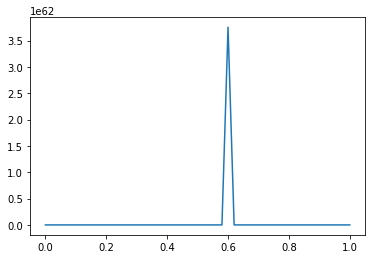

In [4]:
from matplotlib import pyplot as plt
_ = plt.plot(epsilons, loss_epsilons)

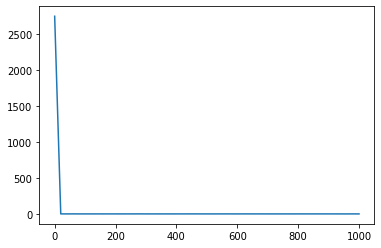

In [5]:
_ = plt.plot(etas, loss_etas)

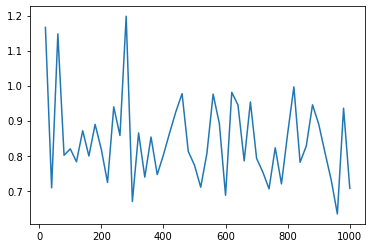

In [6]:
_ = plt.plot(etas[1:], loss_etas[1:])

In [7]:
offset = 0.01
epsilon0 = (1 + offset) * epsilon
eta0 = (1 + offset) * eta
x0 = [epsilon0, eta0]

def print_intermediate(xk):
    print(xk)

from scipy.optimize import minimize
from mitiq.pec.representations.learning import biased_noise_loss_function
result = minimize(
    biased_noise_loss_function,
    x0,
    args=(
        operations,
        training_circuits,
        ideal_values,
        noisy_executor,
        pec_kwargs,
        observable,
    ),
    method="BFGS",
    callback = print_intermediate,
)
x_result = result.x
epsilon_opt =  x_result[0]
eta_opt = x_result[1]
success = result.success
print(result)



print(epsilon_opt, eta_opt, success)

[7.06997647e-01 1.00999999e+03]
      fun: 0.5868537998082328
 hess_inv: array([[1.22141804, 0.37676758],
       [0.37676758, 0.1162205 ]])
      jac: array([4293841.61622319, -928450.54497987])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 51
      nit: 1
     njev: 13
   status: 2
  success: False
        x: array([7.06997647e-01, 1.00999999e+03])
0.706997646808481 1009.9999898203075 False


In [ ]:
training_circuits = generate_training_circuits(
    circuit=circuit,
    num_training_circuits=3,
    fraction_non_clifford=0,
    method_select="uniform",
    method_replace="closest",
)



def biased_noise_channel(epsilon: float, eta: float) -> MixedUnitaryChannel:
    a = 1 - epsilon
    b = epsilon * (3 * eta + 1) / (3 * (eta + 1))
    c = epsilon / (3 * (eta + 1))

    mix = [
        (a, unitary(I)),
        (b, unitary(Z)),
        (c, unitary(X)),
        (c, unitary(Y)),
    ]
    return ops.MixedUnitaryChannel(mix)


operations = [Circuit(CNOT_ops[0][1])]

def noisy_execute(circ: Circuit) -> np.ndarray:
    noisy_circ = circ.with_noise(biased_noise_channel(epsilon, eta))
    return ideal_execute(noisy_circ)

noisy_executor = Executor(noisy_execute)

offset = 0.1
epsilon0 = (1 + offset) * epsilon
eta0 = (1 + offset) * eta
[epsilon_opt, eta_opt, success] = learn_biased_noise_parameters(
        operations_to_learn=operations,
        circuit=circuit,
        ideal_executor=ideal_executor,
        noisy_executor=noisy_executor,
        pec_kwargs=pec_kwargs,
        num_training_circuits=3,
        fraction_non_clifford=0.2,
        epsilon0=epsilon0,
        eta0=eta0,
        observable=observable,
        options={'gtol': 1e-02, 'maxiter': 100, 'disp': True}
    )

print(epsilon_opt, eta_opt, success)

In [ ]:
from mitiq.pec.representations.learning import biased_noise_loss_function
from scipy.optimize import minimize
from typing import cast


offset = 0.01
epsilon0 = (1 + offset) * epsilon
eta0 = (1 + offset) * eta
x0 = np.array(
    [epsilon0, eta0]
)  # initial parameter values for optimization

operations_to_learn = [Circuit(Rz_ops[0][1])]

result = minimize(
    biased_noise_loss_function,
    x0,
    args=(
        operations_to_learn,
        training_circuits,
        ideal_values,
        noisy_executor,
        pec_kwargs,
        observable,
    ),
    method="Nelder-Mead",
    # **minimize_kwargs,
)
x_result = result.x
epsilon_opt = cast(float, x_result[0])
eta_opt = cast(float, x_result[1])
success = cast(bool, result.success)
print(result)

In [ ]:
print(epsilon0)
print(eta0)

In [ ]:
epsilon_opt_test = result.x[0]
eta_opt_test = result.x[1]

test_loss = biased_noise_loss_function(result.x, operations_to_learn, training_circuits, ideal_values, noisy_executor, pec_kwargs, observable)

In [ ]:
print(test_loss)

In [ ]:
initial_loss = biased_noise_loss_function([epsilon0, eta0], operations_to_learn, training_circuits, ideal_values, noisy_executor, pec_kwargs, observable)
print(initial_loss)

In [ ]:
print(epsilon0, eta0)